In [1]:
#https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/
#importing the libraries
#from torchsummary import summary
import pandas as pd
import numpy as np
import cv2
from skimage.io import imread, imsave
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage

In [2]:
# loading dataset
data = pd.read_csv('data.csv')
data.head()


,image,class,images
0,0,0,0.png
1,1,0,1.png
2,2,0,2.png
3,3,0,3.png
4,4,0,4.png


In [3]:
# loading images
train_img = []
#flag_x =0
for img_name in tqdm(data['images']):
    image_path = 'images/' + img_name
    img = imread(image_path)
    img = img/255
    img = np.resize(img,(224,224,3))
    train_img.append(img)
    #print(img.shape)
    '''if (flag_x ==0):
        train_img = img
        flag_x = flag_x +1
        #print("hii")
    else:
        train_img = np.concatenate((train_img,img))
        #train_img = cv2.hconcat([train_img,img])
        #print( train_img.shape)'''
        
train_x = np.array(train_img)
train_y = data['class'].values
train_x.shape, train_y.shape
#print(train_x.shape)

100%|██████████| 277/277 [00:01<00:00, 241.41it/s]


((277, 224, 224, 3), (277,))

In [4]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state = 13, stratify=train_y)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((249, 224, 224, 3), (249,)), ((28, 224, 224, 3), (28,)))

In [5]:
final_train_data = []
final_target_train = []
for i in tqdm(range(train_x.shape[0])):
    final_train_data.append(train_x[i])
    final_train_data.append(rotate(train_x[i], angle=45, mode = 'wrap'))
    final_train_data.append(np.fliplr(train_x[i]))
    final_train_data.append(np.flipud(train_x[i]))
    final_train_data.append(random_noise(train_x[i],var=0.2**2))
    for j in range(5):
        final_target_train.append(train_y[i])

100%|██████████| 249/249 [00:06<00:00, 36.51it/s]


In [6]:
len(final_target_train), len(final_train_data)
final_train = np.array(final_train_data)
final_target_train = np.array(final_target_train)
print(len(final_target_train))
print(len(final_train))
print((final_train.shape))

1245
1245
(1245, 224, 224, 3)


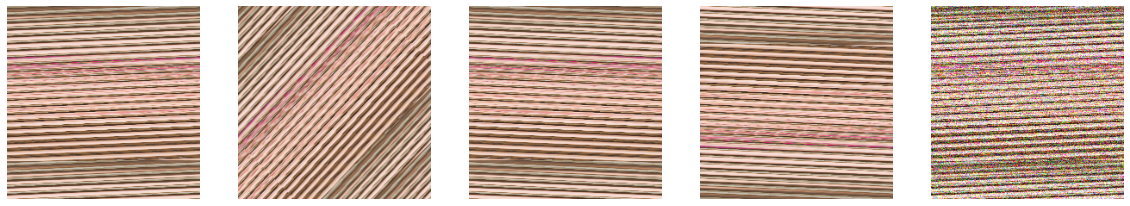

In [7]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(final_train[i+30])
    ax[i].axis('off')

In [9]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [10]:
# converting training images into torch format
final_train = final_train.reshape(1245,3,224,224)
print(final_train.shape)
final_train  = torch.from_numpy(final_train)
final_train = final_train.float()

# converting the target into torch format
final_target_train = final_target_train.astype(int)
final_target_train = torch.from_numpy(final_target_train)

(1245, 3, 224, 224)


In [12]:
val_x = val_x.reshape(28, 3, 224, 224)
val_x  = torch.from_numpy(val_x)
val_x = val_x.float()

# converting the target into torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

TypeError: expected np.ndarray (got Tensor)

In [13]:
torch.manual_seed(0)

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(64),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
        )

        self.linear_layers = Sequential(
            Linear(128 * 14 * 14, 512),
            ReLU(inplace=True),
            Dropout(),
            Linear(512, 256),
            ReLU(inplace=True),
            Dropout(),
            Linear(256,10),
            ReLU(inplace=True),
            Dropout(),
            Linear(10,2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [14]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.000075)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Con

C:\Users\zeinab walid\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [22]:
torch.manual_seed(0)

# batch size of the model
batch_size = 64

# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
        
    permutation = torch.randperm(final_train.size()[0])

    training_loss = []
    for i in tqdm(range(0,final_train.size()[0], batch_size)):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = final_train[indices], final_target_train[indices]
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
      
        optimizer.zero_grad()
        #batch_x = batch_x.long()
        batch_y= batch_y.type(torch.int64)
        #print(batch_x.dtype)
        #print(batch_y.dtype)
        #print(outputs.dtype)
        
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [01:03<20:15, 63.97s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [01:28<15:37, 52.10s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [01:54<12:31, 44.22s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [02:20<10:21, 38.84s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [02:46<08:43, 34.92s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [03:10<07:22, 31.58s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [03:28<05:57, 27.51s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [03:44<04:48, 24.07s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [03:59<03:57, 21.57s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [04:15<03:16, 19.65s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [04:29<02:43, 18.21s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [04:45<02:19, 17.43s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [05:00<01:57, 16.75s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [05:16<01:38, 16.41s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [05:29<01:17, 15.53s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [05:43<01:00, 15.11s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [06:02<00:48, 16.08s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [06:16<00:31, 15.56s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [06:30<00:15, 15.12s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 1 	 training loss: 	 0.6903756469488144
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:08<02:45,  8.72s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:17<02:37,  8.76s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:25<02:26,  8.61s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:34<02:17,  8.56s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:43<02:12,  8.82s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:53<02:05,  8.97s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [01:01<01:55,  8.88s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:10<01:47,  8.93s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:19<01:37,  8.89s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:29<01:30,  9.08s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:38<01:22,  9.13s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:47<01:12,  9.10s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:56<01:03,  9.10s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [02:05<00:54,  9.04s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:13<00:44,  8.92s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:22<00:34,  8.75s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:30<00:26,  8.67s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:39<00:17,  8.64s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:47<00:08,  8.59s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 2 	 training loss: 	 0.6881761282682419
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:08<02:44,  8.66s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:17<02:34,  8.57s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:25<02:25,  8.58s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:33<02:15,  8.47s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:42<02:07,  8.51s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:50<01:57,  8.43s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [00:59<01:49,  8.41s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:07<01:41,  8.44s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:16<01:32,  8.45s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:24<01:23,  8.38s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:32<01:15,  8.40s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:40<01:06,  8.35s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:49<00:58,  8.32s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [01:57<00:49,  8.30s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:05<00:41,  8.36s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:14<00:33,  8.33s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:22<00:25,  8.36s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:31<00:16,  8.41s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:39<00:08,  8.33s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 3 	 training loss: 	 0.6768108546733856
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:09<02:51,  9.01s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:17<02:40,  8.94s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:26<02:32,  8.99s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:35<02:21,  8.82s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:43<02:10,  8.71s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:52<02:00,  8.64s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [01:00<01:50,  8.53s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:08<01:41,  8.49s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:17<01:32,  8.40s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:25<01:24,  8.47s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:34<01:15,  8.44s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:42<01:07,  8.49s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:50<00:58,  8.39s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [01:59<00:50,  8.40s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:07<00:41,  8.36s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:15<00:33,  8.36s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:24<00:25,  8.37s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:32<00:16,  8.41s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:41<00:08,  8.36s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 4 	 training loss: 	 0.6482170343399047
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:08<02:38,  8.36s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:16<02:30,  8.38s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:24<02:21,  8.32s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:33<02:14,  8.39s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:42<02:06,  8.42s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:50<01:57,  8.41s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [00:58<01:49,  8.42s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:07<01:41,  8.45s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:15<01:32,  8.40s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:24<01:24,  8.43s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:32<01:15,  8.37s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:40<01:07,  8.39s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:49<00:58,  8.37s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [01:57<00:50,  8.41s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:05<00:41,  8.36s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:14<00:33,  8.38s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:22<00:25,  8.40s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:31<00:17,  8.52s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:40<00:08,  8.59s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 5 	 training loss: 	 0.5715796530246735
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:08<02:38,  8.34s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:16<02:30,  8.36s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:25<02:22,  8.38s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:33<02:14,  8.41s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:41<02:05,  8.35s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:50<01:58,  8.46s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [00:59<01:50,  8.47s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:07<01:41,  8.46s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:16<01:34,  8.62s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:24<01:25,  8.54s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:33<01:16,  8.55s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:41<01:07,  8.46s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:50<00:59,  8.49s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [01:58<00:51,  8.53s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:07<00:42,  8.50s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:15<00:33,  8.43s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:24<00:25,  8.45s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:32<00:16,  8.35s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:40<00:08,  8.39s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 6 	 training loss: 	 0.4955613449215889
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:08<02:44,  8.65s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:16<02:33,  8.52s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:25<02:24,  8.50s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:33<02:14,  8.42s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:41<02:06,  8.41s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:50<01:56,  8.36s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [00:58<01:49,  8.39s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:06<01:39,  8.33s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:15<01:31,  8.36s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:23<01:23,  8.32s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:31<01:15,  8.37s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:40<01:06,  8.33s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:48<00:59,  8.45s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [01:57<00:51,  8.53s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:06<00:42,  8.54s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:14<00:34,  8.53s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:23<00:25,  8.51s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:31<00:17,  8.51s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:40<00:08,  8.46s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 7 	 training loss: 	 0.4622966229915619
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:08<02:47,  8.81s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:17<02:35,  8.63s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:25<02:26,  8.60s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:33<02:16,  8.54s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:42<02:06,  8.45s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:50<01:57,  8.41s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [00:58<01:48,  8.34s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:07<01:40,  8.36s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:15<01:31,  8.34s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:23<01:23,  8.34s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:31<01:14,  8.29s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:40<01:06,  8.34s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:48<00:58,  8.29s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [01:57<00:50,  8.37s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:05<00:41,  8.32s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:13<00:33,  8.33s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:21<00:24,  8.31s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:30<00:16,  8.36s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:38<00:08,  8.27s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 8 	 training loss: 	 0.39381709396839143
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:08<02:42,  8.54s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:16<02:32,  8.49s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:25<02:22,  8.40s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:33<02:14,  8.41s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:42<02:06,  8.46s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:51<02:00,  8.59s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [00:59<01:52,  8.69s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:09<01:48,  9.07s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:19<01:42,  9.29s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:29<01:35,  9.52s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:39<01:25,  9.54s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:48<01:14,  9.29s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:57<01:04,  9.26s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [02:05<00:54,  9.09s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:14<00:45,  9.08s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:23<00:35,  8.94s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:33<00:27,  9.13s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:42<00:18,  9.13s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:51<00:09,  9.04s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 9 	 training loss: 	 0.3589135631918907
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:08<02:50,  8.95s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:18<02:42,  9.02s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:27<02:34,  9.09s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:36<02:26,  9.13s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:45<02:17,  9.19s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:55<02:08,  9.18s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [01:04<02:00,  9.26s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:14<01:52,  9.40s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:24<01:46,  9.64s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:33<01:35,  9.53s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:42<01:24,  9.41s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:52<01:15,  9.42s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [02:01<01:05,  9.33s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [02:10<00:56,  9.38s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:19<00:46,  9.23s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:29<00:37,  9.27s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:37<00:27,  9.11s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:47<00:18,  9.15s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:55<00:08,  8.97s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 10 	 training loss: 	 0.31493978053331373
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:09<02:52,  9.09s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:18<02:43,  9.07s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:26<02:31,  8.91s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:35<02:23,  8.98s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:45<02:16,  9.08s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:54<02:06,  9.05s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [01:03<01:58,  9.13s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:12<01:50,  9.19s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:21<01:40,  9.11s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:30<01:30,  9.00s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:39<01:20,  8.98s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:48<01:13,  9.14s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:57<01:02,  8.97s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [02:06<00:53,  8.88s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:14<00:44,  8.85s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:24<00:35,  8.94s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:32<00:26,  8.95s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:41<00:17,  8.95s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:50<00:08,  8.97s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 11 	 training loss: 	 0.28914843648672106
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:08<02:50,  8.97s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:18<02:44,  9.15s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:27<02:36,  9.23s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:36<02:25,  9.10s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:45<02:16,  9.08s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:54<02:07,  9.11s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [01:04<01:58,  9.12s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:12<01:46,  8.91s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:21<01:37,  8.91s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:30<01:28,  8.85s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:39<01:20,  8.96s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:47<01:10,  8.83s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:56<01:01,  8.78s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [02:05<00:52,  8.76s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:13<00:43,  8.74s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:23<00:35,  8.91s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:32<00:26,  8.89s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:42<00:18,  9.21s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:50<00:09,  9.09s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 12 	 training loss: 	 0.2629569560289383
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:09<02:52,  9.10s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:18<02:43,  9.08s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:27<02:34,  9.07s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:35<02:22,  8.93s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:44<02:12,  8.84s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:53<02:04,  8.86s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [01:03<02:00,  9.25s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:12<01:51,  9.26s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:22<01:42,  9.33s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:31<01:33,  9.36s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:41<01:24,  9.41s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:50<01:14,  9.36s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:59<01:05,  9.36s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [02:09<00:56,  9.37s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:17<00:45,  9.15s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:27<00:36,  9.19s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:36<00:27,  9.12s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:45<00:18,  9.18s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:54<00:09,  9.23s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 13 	 training loss: 	 0.233962582051754
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:08<02:45,  8.69s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:17<02:37,  8.74s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:26<02:31,  8.93s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:35<02:22,  8.88s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:44<02:14,  8.97s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:53<02:04,  8.92s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [01:03<01:57,  9.05s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:12<01:48,  9.08s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:21<01:41,  9.23s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:30<01:31,  9.11s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:39<01:20,  8.98s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:48<01:13,  9.18s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:58<01:06,  9.45s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [02:08<00:57,  9.55s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:17<00:46,  9.30s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:26<00:36,  9.07s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:34<00:27,  9.03s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:43<00:17,  8.82s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:51<00:08,  8.67s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 14 	 training loss: 	 0.20869881212711333
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:08<02:37,  8.29s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:16<02:30,  8.34s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:25<02:24,  8.53s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:34<02:16,  8.52s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:42<02:08,  8.54s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:51<01:59,  8.50s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [00:59<01:49,  8.43s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:07<01:40,  8.36s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:16<01:32,  8.43s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:24<01:23,  8.35s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:32<01:15,  8.39s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:41<01:07,  8.49s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:50<01:00,  8.68s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [01:59<00:52,  8.81s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:09<00:44,  8.95s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:18<00:36,  9.15s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:27<00:26,  8.91s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:35<00:17,  8.75s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:44<00:08,  8.89s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 15 	 training loss: 	 0.19287937097251415
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:11<03:29, 11.03s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:22<03:20, 11.13s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:32<03:04, 10.88s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:43<02:53, 10.85s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:53<02:40, 10.70s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [01:02<02:22, 10.20s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [01:11<02:07,  9.82s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:20<01:54,  9.58s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:30<01:44,  9.53s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:39<01:35,  9.51s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:48<01:23,  9.26s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:57<01:13,  9.23s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [02:06<01:03,  9.14s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [02:15<00:55,  9.20s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:24<00:45,  9.05s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:34<00:37,  9.39s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:43<00:28,  9.33s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:53<00:18,  9.34s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [03:02<00:09,  9.39s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 16 	 training loss: 	 0.16660230569541454
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:09<02:58,  9.39s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:18<02:47,  9.31s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:27<02:36,  9.19s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:36<02:25,  9.07s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:44<02:14,  8.98s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:53<02:05,  8.95s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [01:03<01:59,  9.21s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:12<01:50,  9.23s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:22<01:43,  9.41s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:31<01:33,  9.33s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:41<01:24,  9.38s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:51<01:16,  9.59s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [02:00<01:06,  9.56s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [02:10<00:56,  9.49s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:19<00:46,  9.25s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:28<00:37,  9.29s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:37<00:27,  9.32s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:46<00:18,  9.14s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:55<00:09,  9.21s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 17 	 training loss: 	 0.14828602522611617
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:10<03:16, 10.34s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:20<03:03, 10.19s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:29<02:50, 10.02s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:39<02:40, 10.02s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:48<02:25,  9.72s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:58<02:15,  9.68s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [01:08<02:06,  9.71s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:17<01:54,  9.54s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:26<01:43,  9.44s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:35<01:33,  9.32s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:44<01:22,  9.17s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:53<01:13,  9.14s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [02:02<01:04,  9.20s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [02:12<00:55,  9.21s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:21<00:46,  9.39s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:32<00:39,  9.79s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:42<00:29,  9.80s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:51<00:19,  9.66s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [03:01<00:09,  9.74s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 18 	 training loss: 	 0.1463471308350563
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:09<02:53,  9.12s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:17<02:42,  9.04s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:26<02:33,  9.01s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:36<02:25,  9.07s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:45<02:16,  9.13s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:54<02:07,  9.09s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [01:03<01:57,  9.05s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:12<01:47,  8.99s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:21<01:39,  9.02s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:30<01:30,  9.07s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:39<01:21,  9.10s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:49<01:13,  9.22s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:58<01:04,  9.21s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [02:08<00:57,  9.52s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:18<00:47,  9.51s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:26<00:36,  9.22s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:35<00:27,  9.09s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:43<00:17,  8.92s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:53<00:08,  9.00s/it]

torch.float32
torch.int64
torch.float32


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 	 19 	 training loss: 	 0.1392509203404188
torch.float32
torch.int64
torch.float32


  5%|▌         | 1/20 [00:08<02:43,  8.59s/it]

torch.float32
torch.int64
torch.float32


 10%|█         | 2/20 [00:17<02:33,  8.54s/it]

torch.float32
torch.int64
torch.float32


 15%|█▌        | 3/20 [00:25<02:24,  8.53s/it]

torch.float32
torch.int64
torch.float32


 20%|██        | 4/20 [00:33<02:16,  8.50s/it]

torch.float32
torch.int64
torch.float32


 25%|██▌       | 5/20 [00:42<02:08,  8.57s/it]

torch.float32
torch.int64
torch.float32


 30%|███       | 6/20 [00:51<01:59,  8.51s/it]

torch.float32
torch.int64
torch.float32


 35%|███▌      | 7/20 [00:59<01:50,  8.53s/it]

torch.float32
torch.int64
torch.float32


 40%|████      | 8/20 [01:08<01:41,  8.49s/it]

torch.float32
torch.int64
torch.float32


 45%|████▌     | 9/20 [01:16<01:33,  8.52s/it]

torch.float32
torch.int64
torch.float32


 50%|█████     | 10/20 [01:25<01:24,  8.50s/it]

torch.float32
torch.int64
torch.float32


 55%|█████▌    | 11/20 [01:33<01:16,  8.52s/it]

torch.float32
torch.int64
torch.float32


 60%|██████    | 12/20 [01:42<01:08,  8.53s/it]

torch.float32
torch.int64
torch.float32


 65%|██████▌   | 13/20 [01:50<00:59,  8.51s/it]

torch.float32
torch.int64
torch.float32


 70%|███████   | 14/20 [01:59<00:51,  8.62s/it]

torch.float32
torch.int64
torch.float32


 75%|███████▌  | 15/20 [02:09<00:45,  9.06s/it]

torch.float32
torch.int64
torch.float32


 80%|████████  | 16/20 [02:21<00:39,  9.79s/it]

torch.float32
torch.int64
torch.float32


 85%|████████▌ | 17/20 [02:30<00:28,  9.62s/it]

torch.float32
torch.int64
torch.float32


 90%|█████████ | 18/20 [02:40<00:19,  9.71s/it]

torch.float32
torch.int64
torch.float32


 95%|█████████▌| 19/20 [02:49<00:09,  9.60s/it]

torch.float32
torch.int64
torch.float32


100%|██████████| 20/20 [02:53<00:00,  8.70s/it]

epoch: 	 20 	 training loss: 	 0.11171563118696212


In [27]:
import os
torch.save(model.state_dict(), 'model_Aug.pt')

RuntimeError: [enforce fail at ..\caffe2\serialize\inline_container.cc:274] . unexpected pos 79744 vs 79632

In [29]:
torch.manual_seed(0)
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(final_train.size()[0])
for i in tqdm(range(0,final_train.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = final_train[indices], final_target_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x)

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████| 20/20 [01:18<00:00,  3.90s/it]


training accuracy: 	 0.9615571120689654


In [30]:
# checking the performance on validation set
torch.manual_seed(0)
output = model(val_x)
softmax = torch.exp(output)
prob = list(softmax.detach().numpy())
predictions = np.argmax(prob, axis=1)
accuracy_score(val_y, predictions)

0.8571428571428571